
## Sagemaker Classification

Classification task on the housing dataset.<br>
Using the features given, XGBoost decision tree model is trained to predict a given person's salary (the `WAGP` column)<br>

--- 

#### Workfloe: 

- Perform EDA on the given dataset
- Save preprocessed datasets to Amazon S3
- Use the Amazon Sagemaker platform to train an XGBoost model
- Evaluate the model using both a Batch-Transform job and a Real Time Predictor
- Perform hyperparameter tuning on the XGBoost model


---

Pandas API documentation: https://pandas.pydata.org/pandas-docs/stable/reference/index.html

Amazon Sagemaker API documentation: https://sagemaker.readthedocs.io/en/stable/

Amazon Sagemaker Tutorials: https://docs.aws.amazon.com/sagemaker/latest/dg/gs.html 

---

### 0.a) Import packages

In [7]:
import boto3, os, sagemaker
from sagemaker import get_execution_role

### 0.b) Get Amazon IAM execution role and instance region

In [8]:
# Define IAM role- this will be necessary when defining your model
iam_role = get_execution_role()

# set the region of the instance and get a reference to the client
my_region = boto3.Session().region_name

# sagemaker session handle
sm_session = sagemaker.session.Session(boto3.Session())

print("Success - the SageMaker instance is in the " + my_region + " region")

Success - the SageMaker instance is in the us-west-2 region


### 1.a) Load CSV data from s3, and the dictionary pickle from local


Upload `person_records_A.csv` and `person_records_B.csv` to S3, into a bucket and folder of your choice. 
Read the data files as Pandas dataframes using their S3 URLs. Read the pickle file by uploading it to the notebook container and using `pickle.load()`. 

### 1.a) Load CSV data from s3, and the dictionary pickle from local


Upload `person_records_A.csv` and `person_records_B.csv` to S3, into a bucket and folder of your choice. 
Read the data files as Pandas dataframes using their S3 URLs. Read the pickle file by uploading it to the notebook container and using `pickle.load()`. 

In [9]:
import pandas as pd
import pickle

bucket ="bigdathw4"
prefix="sagemaker"

data_fname= "s3://bigdathw4/sagemaker/person_records_A.csv".format(bucket,prefix)
df_A = pd.read_csv(data_fname)


data_fname1= "s3://bigdathw4/sagemaker/person_records_B.csv".format(bucket,prefix)
df_B = pd.read_csv(data_fname1)
pickle_in = open("person_ddict.pickle","rb")
pr_ddict = pickle.load(pickle_in)

### 1.b) Examine data schema and counts

In [10]:
type(df_A )

pandas.core.frame.DataFrame

In [11]:
len(df_A)

1613672

In [12]:
len(df_B)

1519123

In [13]:
df_A.head()

,SERIALNO,SPORDER,PUMA,ST,ADJINC,AGEP,CIT,CITWP,COW,DDRS,...,RACWHT,RC,SFN,SFR,SOCP,VPS,WAOB,FHINS3C,FHINS4C,FHINS5C
0,84,1,2600,1,1007549,19,1,NaN,NaN,2.0,...,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
1,154,1,2500,1,1007549,55,1,NaN,1.0,2.0,...,0,0,NaN,NaN,411011,NaN,1,NaN,NaN,NaN
2,154,2,2500,1,1007549,56,1,NaN,6.0,2.0,...,0,0,NaN,NaN,493050,NaN,1,NaN,NaN,NaN
3,154,3,2500,1,1007549,21,1,NaN,NaN,2.0,...,0,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
4,154,4,2500,1,1007549,21,1,NaN,NaN,1.0,...,0,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN


In [14]:
print(df_A.columns)

Index(['SERIALNO', 'SPORDER', 'PUMA', 'ST', 'ADJINC', 'AGEP', 'CIT', 'CITWP',
       'COW', 'DDRS',
       ...
       'RACWHT', 'RC', 'SFN', 'SFR', 'SOCP', 'VPS', 'WAOB', 'FHINS3C',
       'FHINS4C', 'FHINS5C'],
      dtype='object', length=127)


In [15]:
df_B.head()

,SERIALNO,SPORDER,PUMA,ST,ADJINC,AGEP,CIT,CITWP,COW,DDRS,...,RACWHT,RC,SFN,SFR,SOCP,VPS,WAOB,FHINS3C,FHINS4C,FHINS5C
0,76,1,1802,29,1007549,21,1,NaN,1.0,2.0,...,0,0,NaN,NaN,433031,NaN,1,NaN,NaN,NaN
1,76,2,1802,29,1007549,22,1,NaN,1.0,2.0,...,0,0,NaN,NaN,412010,NaN,1,NaN,NaN,NaN
2,80,1,901,29,1007549,21,1,NaN,NaN,2.0,...,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
3,86,1,1600,29,1007549,58,1,NaN,1.0,2.0,...,1,0,NaN,NaN,439061,6.0,1,0.0,NaN,NaN
4,86,2,1600,29,1007549,52,1,NaN,6.0,2.0,...,1,0,NaN,NaN,132011,NaN,1,NaN,NaN,NaN


In [16]:
print(df_B.columns)

Index(['SERIALNO', 'SPORDER', 'PUMA', 'ST', 'ADJINC', 'AGEP', 'CIT', 'CITWP',
       'COW', 'DDRS',
       ...
       'RACWHT', 'RC', 'SFN', 'SFR', 'SOCP', 'VPS', 'WAOB', 'FHINS3C',
       'FHINS4C', 'FHINS5C'],
      dtype='object', length=127)


### 1.c) Select only necessary data columns



In [17]:
colNames = ['AGEP', 'DDRS', 'COW', 'WAGP', 'JWMNP', 'JWTR', 'MAR', 'PERNP', 'NWAV', 
            'NWLA', 'NWLK', 'NWAB', 'SCHL', 'WKW', 'FOD1P', 'FOD2P']

for c in colNames:
    print(c,'\t', pr_ddict[c]['description']) 

AGEP 	 Age
DDRS 	 Self-care difficulty
COW 	 Class of worker
WAGP 	 Wages or salary income past 12 months
JWMNP 	 Travel time to work
JWTR 	 Means of transportation to work
MAR 	 Marital status
PERNP 	 Total person's earnings
NWAV 	 Available for work
NWLA 	 On layoff from work
NWLK 	 Looking for work
NWAB 	 Temporary absence from work
SCHL 	 Educational attainment
WKW 	 Weeks worked during past 12 months
FOD1P 	 Recoded field of degree - first entry
FOD2P 	 Recoded field of degree - second entry


In [18]:
dfA= df_A[colNames]

In [19]:
dfA.head()

,AGEP,DDRS,COW,WAGP,JWMNP,JWTR,MAR,PERNP,NWAV,NWLA,NWLK,NWAB,SCHL,WKW,FOD1P,FOD2P
0,19,2.0,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN,NaN,NaN
1,55,2.0,1.0,52000.0,30.0,1.0,1,52000.0,5.0,3.0,3.0,3.0,20.0,1.0,NaN,NaN
2,56,2.0,6.0,0.0,NaN,11.0,1,99000.0,5.0,3.0,3.0,3.0,16.0,1.0,NaN,NaN
3,21,2.0,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN,NaN,NaN
4,21,1.0,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN,NaN,NaN


In [20]:
dfB= df_B[colNames]

In [21]:
dfB.head()

,AGEP,DDRS,COW,WAGP,JWMNP,JWTR,MAR,PERNP,NWAV,NWLA,NWLK,NWAB,SCHL,WKW,FOD1P,FOD2P
0,21,2.0,1.0,20400.0,20.0,1.0,5,20400.0,5.0,3.0,3.0,3.0,19.0,1.0,NaN,NaN
1,22,2.0,1.0,16700.0,20.0,1.0,5,16700.0,5.0,3.0,3.0,3.0,19.0,1.0,NaN,NaN
2,21,2.0,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN,NaN,NaN
3,58,2.0,1.0,0.0,NaN,NaN,1,0.0,5.0,2.0,2.0,2.0,21.0,NaN,6203.0,NaN
4,52,2.0,6.0,0.0,20.0,1.0,1,60000.0,5.0,3.0,3.0,3.0,22.0,1.0,6203.0,NaN


### 1.d) Merge dataframes and select columns

 

In [22]:
import pandas
colNames = ['AGEP', 'DDRS', 'COW', 'WAGP', 'JWMNP', 'JWTR', 'MAR', 'PERNP', 'NWAV', 
            'NWLA', 'NWLK', 'NWAB', 'SCHL', 'WKW', 'FOD1P', 'FOD2P']

df =pandas.concat([dfA, dfB])


In [23]:
df.head()

,AGEP,DDRS,COW,WAGP,JWMNP,JWTR,MAR,PERNP,NWAV,NWLA,NWLK,NWAB,SCHL,WKW,FOD1P,FOD2P
0,19,2.0,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN,NaN,NaN
1,55,2.0,1.0,52000.0,30.0,1.0,1,52000.0,5.0,3.0,3.0,3.0,20.0,1.0,NaN,NaN
2,56,2.0,6.0,0.0,NaN,11.0,1,99000.0,5.0,3.0,3.0,3.0,16.0,1.0,NaN,NaN
3,21,2.0,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN,NaN,NaN
4,21,1.0,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN,NaN,NaN


### 1.e) Dataframe statistics



In [24]:
df.corr()

,AGEP,DDRS,COW,WAGP,JWMNP,JWTR,MAR,PERNP,NWAV,NWLA,NWLK,NWAB,SCHL,WKW,FOD1P,FOD2P
AGEP,1.000000,-0.202793,0.131413,-0.034028,0.034882,-0.009769,-0.661755,-0.040249,0.054485,-0.184933,-0.120735,-0.175368,0.485370,-0.167503,-0.062601,-0.017541
DDRS,-0.202793,1.000000,-0.007077,0.100952,0.000159,-0.009330,0.030406,0.104053,-0.020772,0.079400,0.061936,0.082724,0.039044,-0.034643,0.011499,-0.003485
COW,0.131413,-0.007077,1.000000,-0.062779,-0.036895,0.154842,-0.080534,0.018897,-0.086982,-0.051587,-0.091308,-0.073266,0.061125,0.004581,-0.035054,-0.021340
WAGP,-0.034028,0.100952,-0.062779,1.000000,0.105639,-0.026631,-0.167817,0.950729,0.110071,0.334439,0.325355,0.323822,0.291967,-0.303953,0.041948,0.042199
JWMNP,0.034882,0.000159,-0.036895,0.105639,1.000000,-0.017564,-0.043957,0.099061,-0.008073,-0.013600,-0.011464,-0.012463,0.023012,-0.036384,0.031991,0.018451
JWTR,-0.009769,-0.009330,0.154842,-0.026631,-0.017564,1.000000,0.051476,0.000308,0.006666,0.029707,0.020912,0.028251,0.016093,0.066099,-0.005989,-0.009296
MAR,-0.661755,0.030406,-0.080534,-0.167817,-0.043957,0.051476,1.000000,-0.165836,-0.077744,-0.008850,-0.050454,-0.007295,-0.447047,0.210344,0.032104,0.013089
PERNP,-0.040249,0.104053,0.018897,0.950729,0.099061,0.000308,-0.165836,1.000000,0.111022,0.337121,0.327888,0.325328,0.285975,-0.302189,0.045455,0.047522
NWAV,0.054485,-0.020772,-0.086982,0.110071,-0.008073,0.006666,-0.077744,0.111022,1.000000,0.404554,0.576910,0.269897,0.038059,-0.271773,-0.005600,-0.007673
NWLA,-0.184933,0.079400,-0.051587,0.334439,-0.013600,0.029707,-0.008850,0.337121,0.404554,1.000000,0.860415,0.863896,0.151322,-0.365991,0.041860,0.022446


In [25]:
print('Correlations of PERNP with WAGP')
df[['PERNP','WAGP']].corr()


Correlations of PERNP with WAGP


,PERNP,WAGP
PERNP,1.000000,0.950729
WAGP,0.950729,1.000000


In [26]:
print('Correlations of NWLA with WAGP')
df[['NWLA','WAGP']].corr()

Correlations of NWLA with WAGP


,NWLA,WAGP
NWLA,1.000000,0.334439
WAGP,0.334439,1.000000


In [27]:
print('Correlations of NWAB with WAGP')
df[['NWAB','WAGP']].corr()

Correlations of NWAB with WAGP


,NWAB,WAGP
NWAB,1.000000,0.323822
WAGP,0.323822,1.000000


In [28]:
print('Correlations of WKW with WAGP')
df[['WKW','WAGP']].corr()

Correlations of WKW with WAGP


,WKW,WAGP
WKW,1.000000,-0.303953
WAGP,-0.303953,1.000000


In [29]:
print('Correlations of NWLK with WAGP')
df[['NWLK','WAGP']].corr()

Correlations of NWLK with WAGP


,NWLK,WAGP
NWLK,1.000000,0.325355
WAGP,0.325355,1.000000


In [30]:
print("WAGP statistics")
df[['WAGP']].describe()
# YOUR CODE HERE

WAGP statistics


,WAGP
count,2.582042e+06
mean,2.565256e+04
std,4.736001e+04
min,0.000000e+00
25%,0.000000e+00
50%,6.000000e+03
75%,3.600000e+04
max,6.600000e+05


## 2) Prepare data

### 2.a) Outlier Removal

Remove outlier rows based on values in the `WAGP` column. 

Based on the output in **1.e)**, it's clear that we need an **upper limit** to filter out significant outliers.



In [31]:
# Select the number of standard deviations you want to set as the upper limit
nStddevs = 5
    
# find the mean and standard deviations of the WAGP column. 
mean= df[['WAGP']].mean()
std_dev= df[['WAGP']].std()

# Calculate the value of your WAGP upper limit using the calculated mean and standard deviation
upper_limt = mean+nStddevs*std_dev

# Select rows using the WAGP upper limit you have just calculated
df_u=df[df.WAGP <=upper_limt[0]]

# print the first 5 rows of the filtered dataframe
df_u.head()

,AGEP,DDRS,COW,WAGP,JWMNP,JWTR,MAR,PERNP,NWAV,NWLA,NWLK,NWAB,SCHL,WKW,FOD1P,FOD2P
0,19,2.0,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN,NaN,NaN
1,55,2.0,1.0,52000.0,30.0,1.0,1,52000.0,5.0,3.0,3.0,3.0,20.0,1.0,NaN,NaN
2,56,2.0,6.0,0.0,NaN,11.0,1,99000.0,5.0,3.0,3.0,3.0,16.0,1.0,NaN,NaN
3,21,2.0,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN,NaN,NaN
4,21,1.0,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN,NaN,NaN


In [32]:
print("upper limit above which you consider samples to be outliers")
upper_limt[0]

upper limit above which you consider samples to be outliers


262452.61065615324

In [33]:
df_u[['WAGP']].describe()

,WAGP
count,2.562699e+06
mean,2.284587e+04
std,3.414597e+04
min,0.000000e+00
25%,0.000000e+00
50%,5.200000e+03
75%,3.500000e+04
max,2.620000e+05


In [34]:
print("no of rows before removal")
len(df)

no of rows before removal


3132795

In [35]:
print("no of rows after removal")
len(df_u)

no of rows after removal


2562699

In [36]:
print("no of outliers")
len(df)-len(df_u)

no of outliers


570096

### 2.b) Feature Selection and Cleaning

Populate `featureCols` with a subset of features from `colNames`.<br>
Create a new DataFrame that contains only columns `featureCols` and `labelCol`.<br>
Drop rows with any nulls in the selected columns.<br>


In [37]:
featureCols = ['JWMNP', 'JWTR', 'MAR', 'PERNP', 'NWAV', 
                'NWLA', 'NWLK', 'NWAB', 'SCHL', 'WKW', 'FOD1P']
labelCol = 'WAGP'

feature_selection_df =df_u[['WAGP','JWMNP', 'JWTR', 'MAR', 'PERNP', 'NWAV', 
                'NWLA', 'NWLK', 'NWAB', 'SCHL', 'WKW', 'FOD1P']]
df_cleaned = feature_selection_df.dropna()



In [38]:
df_cleaned.head()

,WAGP,JWMNP,JWTR,MAR,PERNP,NWAV,NWLA,NWLK,NWAB,SCHL,WKW,FOD1P
5,39000.0,15.0,1.0,3,39000.0,5.0,3.0,3.0,3.0,21.0,1.0,6107.0
16,20000.0,5.0,1.0,1,20000.0,5.0,3.0,3.0,3.0,21.0,1.0,5500.0
36,100000.0,5.0,1.0,1,100000.0,5.0,3.0,2.0,2.0,21.0,1.0,6107.0
56,41000.0,20.0,1.0,1,41000.0,5.0,3.0,3.0,3.0,21.0,1.0,3700.0
60,25000.0,35.0,1.0,5,25000.0,5.0,3.0,3.0,3.0,21.0,1.0,1303.0


In [39]:
len(df_cleaned)

430272

In [40]:
# no of features
len(featureCols)

11

### 2.c) Discretize salary

We want to convert the WAGP column, which contains continuous values, into a column with discrete labels so that we can use it as the label column for our classification problem. 


In [41]:
import matplotlib.pyplot as plt

# Make sure labels start from 0

df_cleaned['WAGP_CAT'] = pd.qcut(df_cleaned['WAGP'],6,labels=False)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
df_cleaned.head()

,WAGP,JWMNP,JWTR,MAR,PERNP,NWAV,NWLA,NWLK,NWAB,SCHL,WKW,FOD1P,WAGP_CAT
5,39000.0,15.0,1.0,3,39000.0,5.0,3.0,3.0,3.0,21.0,1.0,6107.0,2
16,20000.0,5.0,1.0,1,20000.0,5.0,3.0,3.0,3.0,21.0,1.0,5500.0,1
36,100000.0,5.0,1.0,1,100000.0,5.0,3.0,2.0,2.0,21.0,1.0,6107.0,4
56,41000.0,20.0,1.0,1,41000.0,5.0,3.0,3.0,3.0,21.0,1.0,3700.0,2
60,25000.0,35.0,1.0,5,25000.0,5.0,3.0,3.0,3.0,21.0,1.0,1303.0,1


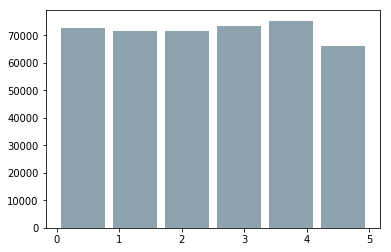

In [42]:
n, bins, patches = plt.hist(x=df_cleaned['WAGP_CAT'], bins=6, color='#607c8e',
                            alpha=0.7, rwidth=0.85)

In [43]:
df_cleaned.groupby('WAGP_CAT').count()

,WAGP,JWMNP,JWTR,MAR,PERNP,NWAV,NWLA,NWLK,NWAB,SCHL,WKW,FOD1P
WAGP_CAT,,,,,,,,,,,,
0,72607,72607,72607,72607,72607,72607,72607,72607,72607,72607,72607,72607
1,71576,71576,71576,71576,71576,71576,71576,71576,71576,71576,71576,71576
2,71643,71643,71643,71643,71643,71643,71643,71643,71643,71643,71643,71643
3,73212,73212,73212,73212,73212,73212,73212,73212,73212,73212,73212,73212
4,75287,75287,75287,75287,75287,75287,75287,75287,75287,75287,75287,75287
5,65947,65947,65947,65947,65947,65947,65947,65947,65947,65947,65947,65947


In [44]:
# Make sure label columns is the first column, and drop WAGP (will make problem trivial otherwise)
# XGBoost expects labels to be in the first column

# YOUR CODE HERE
df1= df_cleaned.drop(['WAGP'], axis = 1) 
df_cleaned2=df1[['WAGP_CAT','JWMNP', 'JWTR', 'MAR', 'PERNP', 'NWAV', 
                'NWLA', 'NWLK', 'NWAB', 'SCHL', 'WKW', 'FOD1P']]

In [45]:
df_cleaned2.head()

,WAGP_CAT,JWMNP,JWTR,MAR,PERNP,NWAV,NWLA,NWLK,NWAB,SCHL,WKW,FOD1P
5,2,15.0,1.0,3,39000.0,5.0,3.0,3.0,3.0,21.0,1.0,6107.0
16,1,5.0,1.0,1,20000.0,5.0,3.0,3.0,3.0,21.0,1.0,5500.0
36,4,5.0,1.0,1,100000.0,5.0,3.0,2.0,2.0,21.0,1.0,6107.0
56,2,20.0,1.0,1,41000.0,5.0,3.0,3.0,3.0,21.0,1.0,3700.0
60,1,35.0,1.0,5,25000.0,5.0,3.0,3.0,3.0,21.0,1.0,1303.0


### 2.d) Save preprocessed data to s3



In [46]:
# shuffle data and train/val/test split, at 6:2:2

import numpy as np

x_train_df, x_val_df, x_test_df = \
    np.split(df_cleaned2.sample(frac=1, random_state=1729), 
             [int(0.6 * len(df_cleaned2)), int(0.8*len(df_cleaned2))]) 

x_train = x_train_df.values
x_val = x_val_df.values
x_test = x_test_df.values[:,1:]  # remove the label column

In [47]:
# split test data into chunks separately
import os 
if not os.path.exists("test_split"):
    os.makedirs("test_split")
row_lim = 10000
num_chunks = int((x_test.shape[0] / row_lim) + 1)
for i in range(num_chunks):
    file = "{}/test_data_split/data_{}.csv".format(prefix, i)
    location = "s3://{}/{}".format(bucket, file)
    x_test_chunk = x_test[i*row_lim:(i+1)*row_lim]
    np.savetxt("test_split/data_{}.csv".format(i), x_test_chunk, delimiter=',')
    boto3.Session().resource('s3').Bucket(bucket).Object(file).upload_file("test_split/data_{}.csv".format(i))
test_split_location = 's3://{}/{}/test_data_split'.format(bucket,prefix)
print('Split Test data will be uploaded to: {}'.format(test_split_location))


Split Test data will be uploaded to: s3://bigdathw4/sagemaker/test_data_split


In [48]:
# save preprocessed data to s3 for XGBoost to access

bucket = "bigdathw4"       # CHANGE ME: your own bucket
prefix = "sagemaker"   # CHANGE ME: your own folder

datasets = [('train', x_train), ('val', x_val), ('test', x_test)]  # Note: also using val as test
data_locations = []
for key, x in datasets:
    file = "{}/{}_data/data.csv".format(prefix,key)
    location = "s3://{}/{}".format(bucket, file); data_locations += [location]
    print('{} data will be uploaded to: {}'.format(key, location))
    np.savetxt("{}.csv".format(key), x, delimiter=',')
    boto3.Session().resource('s3').Bucket(bucket).Object(file).upload_file("{}.csv".format(key))

train data will be uploaded to: s3://bigdathw4/sagemaker/train_data/data.csv
val data will be uploaded to: s3://bigdathw4/sagemaker/val_data/data.csv
test data will be uploaded to: s3://bigdathw4/sagemaker/test_data/data.csv


In [49]:
# set model output location

output_location = "s3://bigdathw4/sagemaker/output".format(bucket,prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://bigdathw4/sagemaker/output


## 3) Train a XGBoost model with static hyperparameters

### 3.1) Train the model

Call the Amazon Sagemaker API to spawn a training container for XGBoost.



In [50]:
# create input channels to stream data
# NOTE: in the case of using CSV files, all data is saved to the worker containers before training starts;
#       only libsvm supports real data streaming

train_channel = sagemaker.inputs.s3_input(data_locations[0], content_type='text/csv')
val_channel = sagemaker.inputs.s3_input(data_locations[1], content_type='text/csv')

data_channels = {'train': train_channel, 'validation': val_channel}

In [51]:
# create the estimator instance

from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')
smclient = boto3.Session().client('sagemaker')

xgb_model = sagemaker.estimator.Estimator(training_image,
                                          iam_role, 
                                          train_instance_count=1, 
                                          train_instance_type='ml.m5.xlarge',
                                          train_volume_size = 5,
                                          output_path=output_location,
                                          sagemaker_session=sagemaker.Session())

In [52]:
# set estimator hyperparameters, these will be passed to the XGBoost container

xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              objective = "multi:softmax",
                              num_class = 6,
                              num_round = 10)

In [53]:
# fit using the data channels

xgb_model.fit(data_channels)

2020-03-11 02:56:05 Starting - Starting the training job...
2020-03-11 02:56:05 Starting - Launching requested ML instances......
2020-03-11 02:57:09 Starting - Preparing the instances for training...
2020-03-11 02:58:00 Downloading - Downloading input data
2020-03-11 02:58:00 Training - Downloading the training image...
2020-03-11 02:58:24 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[02:58:25] 258163x11 matrix with 2839793 entries loaded from /opt/ml/inpu

In [54]:
# print the model's S3 URL
xgb_model.model_data

's3://bigdathw4/sagemaker/output/sagemaker-xgboost-2020-03-11-02-56-04-939/output/model.tar.gz'

### 3.2) Getting a transformer for batch inferencing

A Transformer spawns a Batch-Transform job using a trained model, and predicts labels for pre-uploaded data on S3. This is mainly for when we have a large amount of data to run inference on, and don't need to get results back in real time. 



In [49]:
test_output_location = output_location+"/results"
print('test outputs will be uploaded to: {}'.format(test_output_location))

test outputs will be uploaded to: s3://bigdathw4/sagemaker/output/results


In [50]:
xgb_transformer = xgb_model.transformer(instance_count=1,
                                        instance_type='ml.m5.xlarge',
                                        output_path=test_output_location)

In [51]:
xgb_transformer.transform(test_split_location,
                          content_type="text/csv")

### 3.3) Deploy model for interactive inference

Real Time Predictors are live services run on Amazon servers, which accepts streamed data (i.e. from live sensors or user input) and uses a trained model to make predictions in real time, hence the name. These predictors are backed by an entire stack of different services and networks, and thus takes some time to startup. 

Since the predictors work only with byte streams and not standard python objects, we have written a simple utility that takes care of data processing for you. 

In [65]:
def predict_file(input_path, predictor, limit=1000):
    """ 
    Utility for piping a local test file to Sagemaker's Real Time Predictor interface 
    Returns a numpy array of integers as the predicted labels
    
    input_path: path to the input CSV file. This should be a local file, you can use "test.csv"
    predictor: the predictor object we created for you
    limit: the max number of data points to send to the predictor. We have set this to 1000 for you. 
    """
    res = []
    with open(input_path, 'r') as f:
        lines = f.readlines()
    for i, l in enumerate(lines):
        res += [predictor.predict(l)]
        print("Progress: {}/{}".format(i, len(lines)), end='\r')
        if limit is not None and i >= limit-1:
            break
    y_pred = np.array([float(e.decode('utf-8')) for e in res]).astype(int)
    return y_pred

In [53]:
# Deploy the real time predictor on Amazon servers. This will take several minutes. 
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                 content_type='text/csv',
                                 instance_type='ml.t2.xlarge')

Using already existing model: sagemaker-xgboost-2020-03-10-17-24-18-396


-----------------!

In [54]:
# run inference and get reports
# NOTE: XGBoost's RealTimePredictor accepts only strings in CSV format. 

from sklearn.metrics import confusion_matrix, classification_report

# Hint: Use the predict_file() method we have provided

y_predict=predict_file("test.csv", xgb_predictor, limit=1000)

In [67]:

y_test =x_test_df.values[:,:1]

classification_report(y_test[:1000], y_predict)

'              precision    recall  f1-score   support\n\n         0.0       0.96      0.80      0.87       155\n         1.0       0.93      0.95      0.94       170\n         2.0       0.97      0.97      0.97       177\n         3.0       0.93      0.99      0.96       166\n         4.0       0.95      0.99      0.97       179\n         5.0       0.96      0.99      0.97       153\n\n   micro avg       0.95      0.95      0.95      1000\n   macro avg       0.95      0.95      0.95      1000\nweighted avg       0.95      0.95      0.95      1000\n'

In [56]:
confusion_matrix(y_test[:1000], y_predict)

array([[124,  12,   5,   5,   5,   4],
       [  2, 162,   1,   5,   0,   0],
       [  1,   1, 171,   2,   1,   1],
       [  0,   0,   0, 164,   2,   0],
       [  1,   0,   0,   0, 177,   1],
       [  0,   0,   0,   0,   1, 152]])

In [57]:
# delete the endpoint after inference to save cost; you may also delete the model.
xgb_predictor.delete_endpoint()
# xgb_predictor.delete_model()

In [55]:
xgb_predictor.delete_model()

NameError: name 'xgb_predictor' is not defined

## 4)Hyperparameter tuning 

The above static XGBoost hyperparameters are not optimal for this dataset. Use Sagemaker's Automatic Hyperparameter Tuning functionality to find the best set of hyperparameters and the resulting model. 

### 4.1) Start a Hyperparameter Tuning Job

Use the sample tuning configurations to launch a hyperparameter tuning job. 



In [58]:
# You need to change the job name every time. 
# Amazon likely uses job logs to bill users, so jobs cannot be deleted or overwritten.
tuning_job_name = "MyTuningJob8"   

# tuning configs: parameter ranges
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {                    # Example, uncomment to also tune this hyperparam
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta"
        },
        {                    # Example, uncomment to also tune this hyperparam
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight"
        }
      
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "20",
          "MinValue": "1",
          "Name": "max_depth"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 10,    # Set the number of iterations here
      "MaxParallelTrainingJobs": 2      # Set the max concurrent training jobs
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:f1",
      "Type": "Maximize"
    }
  }

# Training job definition: data sources, instance config, static hyperparams
training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": training_image,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": data_locations[0]
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": data_locations[1]
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": output_location
    },
    "ResourceConfig": {
      "InstanceCount": 2,
      "InstanceType": "ml.c4.2xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": iam_role,
    "StaticHyperParameters": {        # Set static hyperparameters here, these won't be tuned
      "gamma": "4",
      "objective": "multi:softmax",
      "num_class": "6",
      "num_round": "10"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 3600
    }
}

In [59]:
# create hyperparam tuning job
smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-west-2:533479762620:hyper-parameter-tuning-job/mytuningjob8',
 'ResponseMetadata': {'RequestId': 'ff332478-43ae-4cc9-8bda-2712b32dd810',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ff332478-43ae-4cc9-8bda-2712b32dd810',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '113',
   'date': 'Wed, 11 Mar 2020 03:00:43 GMT'},
  'RetryAttempts': 0}}

### 4.2) Rerun validation to examine model performance

After the hyperparameter tuning job is complete, find the URL of the model file of your best performing model, by:
1. Go to the Hyperparameter tuning jobs page on SageMaker console
2. Select Best Training Job, and go to the job's details page
3. Scroll to the bottom of the page, there is a URL to the saved model file (ending with `.tar.gz`). 

Copy this URL as `model_location_s3`, run below cells, and report model performance in the same way as **3.3)**

In [62]:
from sagemaker.model import Model

model_location_s3 = "s3://bigdathw4/sagemaker/output/MyTuningJob8-006-d07bf0d3/output/model.tar.gz"  # S3 Path to your model artifact

tuned_model = Model(model_location_s3, 
                    image=training_image,
                    role=iam_role, 
                    sagemaker_session=sm_session
                   )
tuned_model.deploy(initial_instance_count=1,
                   instance_type='ml.m4.xlarge',
                  )

-------------------!

In [63]:
from sagemaker.predictor import RealTimePredictor
tuned_predictor = RealTimePredictor(tuned_model.endpoint_name,
                                    sm_session,
                                    content_type='text/csv')

In [68]:
# run inference and get reports
# NOTE: XGBoost's RealTimePredictor accepts only strings in CSV format. 

from sklearn.metrics import confusion_matrix, classification_report

# YOUR CODE HERE
y_predict=predict_file("test.csv", tuned_predictor , limit=1000)
classification_report(y_test[:1000], y_predict)

'              precision    recall  f1-score   support\n\n         0.0       0.96      0.80      0.87       155\n         1.0       0.93      0.95      0.94       170\n         2.0       0.97      0.97      0.97       177\n         3.0       0.93      0.99      0.96       166\n         4.0       0.95      0.99      0.97       179\n         5.0       0.96      0.99      0.97       153\n\n   micro avg       0.95      0.95      0.95      1000\n   macro avg       0.95      0.95      0.95      1000\nweighted avg       0.95      0.95      0.95      1000\n'

In [69]:
confusion_matrix(y_test[:1000], y_predict)

array([[124,  12,   5,   5,   5,   4],
       [  2, 162,   1,   5,   0,   0],
       [  1,   1, 171,   2,   1,   1],
       [  0,   0,   0, 164,   2,   0],
       [  1,   0,   0,   0, 177,   1],
       [  1,   0,   0,   0,   1, 151]])

In [70]:
# delete model and endpoint after inference to save cost

tuned_predictor.delete_endpoint()
tuned_predictor.delete_model()